In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
from jax import vmap, jit

In [2]:
from evosax.problems.pendulum import reset, step
from evosax.strategies.cma_es import init_strategy, ask, tell, check_termination
from evosax.utils import init_logger, update_logger, flat_to_mlp
from examples.ffw_pendulum import pendulum_rollout, init_policy_mlp

In [3]:
rng = jax.random.PRNGKey(0)

env_params = {"max_speed": 8,
              "max_torque": 2.,
              "dt": 0.05,
              "g": 10.0,
              "m": 1.,
              "l": 1.}

# Episode Rollout from Randomly Init Policy

In [4]:
# Rollout single episode with lax.scan
rng, rng_input = jax.random.split(rng)
policy_params = init_policy_mlp(rng_input, 1, [3, 16, 1], scale=1e-2)

rng, rng_input = jax.random.split(rng)
pendulum_rollout(rng_input, policy_params, env_params, num_steps=200)

DeviceArray(-600.16327, dtype=float32)

# Vectorized Parallel Rollout of Eps with vmap

In [5]:
# Rollout a batch of parallel episodes using vmap
batch_rollout = jit(vmap(pendulum_rollout, in_axes=(0, None, None, None), out_axes=0),
                    static_argnums=(3))
rng, rng_input = jax.random.split(rng)
rollout_keys = jax.random.split(rng_input, 10)
batch_rollout(rollout_keys, policy_params, env_params, 200)

DeviceArray([ -626.7644 , -1068.5372 , -1775.2993 , -1148.9524 ,
              -863.4879 ,  -710.92145,  -940.70044, -1348.8433 ,
             -1785.6411 , -1167.9045 ], dtype=float32)

In [6]:
# Generate a batch of 5 weight initialisations
generation_params = init_policy_mlp(rng_input, 5, [3, 16, 1], scale=1e-2)

In [7]:
# Rollout 10 episodes for 5 agents in parallel
v_dict = {"W1": 0, "b1": 0, "W2": 0, "b2": 0}
generation_rollout = jit(vmap(batch_rollout, in_axes=(None, v_dict, None, None),
                              out_axes=0), static_argnums=(2, 3))
results = generation_rollout(rollout_keys, generation_params, env_params, 200)
print(results.shape)

(5, 10)


In [8]:
# Sanity check on one of the 5
i = 1
policy_sub = {"W1": generation_params["W1"][i],
              "b1": generation_params["b1"][i],
              "W2": generation_params["W2"][i],
              "b2": generation_params["b2"][i]}
batch_rollout(rollout_keys, policy_sub, env_params, 200)

DeviceArray([ -686.62976, -1067.7191 , -1773.2311 , -1146.1252 ,
              -863.0676 ,  -747.9819 ,  -955.11475, -1351.1321 ,
             -1787.5454 , -1167.5414 ], dtype=float32)

# Neuroevolution with CMA-ES

In [9]:
num_params = 3*32 + 32 + 32*1 + 1
rng = jax.random.PRNGKey(0)
mean_init, sigma_init = jnp.zeros(num_params), 0.1
pop_size, mu = 500, 250
num_evals_per_gen = 50
num_generations = 500

params, memory = init_strategy(mean_init, sigma_init, pop_size, mu)

In [10]:
mean_init.shape[0]

161

In [11]:
x, memory = ask(rng, memory, params)

In [12]:
generation_params = flat_to_mlp(x, sizes=[3, 32, 1])
rng, rng_input = jax.random.split(rng)
rollout_keys = jax.random.split(rng_input, num_evals_per_gen)

population_returns = generation_rollout(rollout_keys, generation_params, env_params, 200)
value = - population_returns.mean(axis=1)
memory = tell(x, value, params, memory)
memory["mean"][0], memory["C"][0, 0]

(DeviceArray(0.00636694, dtype=float32), DeviceArray(1.0010186, dtype=float32))

# Run generation loop on Pendulum Task

In [13]:
rng = jax.random.PRNGKey(1234)

num_params = 3*48 + 48 + 48*1 + 1
pop_size, elite_size = 100, 50
mean_init, sigma_init = jnp.zeros(num_params), 1

top_k = 5
evo_logger = init_logger(top_k, num_params)

params, memory = init_strategy(mean_init, sigma_init,
                               pop_size, elite_size)

for g in range(num_generations):
    rng, rng_input = jax.random.split(rng)
    x, memory = ask(rng_input, memory, params)
    generation_params = flat_to_mlp(x, sizes=[3, 48, 1])
    rng, rng_input = jax.random.split(rng)
    rollout_keys = jax.random.split(rng_input, num_evals_per_gen)

    population_returns = generation_rollout(rollout_keys, generation_params,
                                            env_params, 200)
    values = - population_returns.mean(axis=1)
    memory = tell(x, values, params, memory)
    evo_logger = update_logger(evo_logger, x, values, memory, top_k)
    if (g + 1) in [50, 100, 150, 200, 300, 350, 400, 450, 500]:
        print(g+1, values.min(), evo_logger["top_values"][0])
        # jnp.save("gen_" + str(g+1), evo_logger["top_params"])
        if check_termination(values, params, memory):
            break

50 743.77435 484.51453
100 239.06216 239.06216
150 155.22375 134.20227
200 145.16315 119.35045
300 136.84857 115.543396
350 159.08853 115.543396
400 149.14389 114.748474
450 142.78395 114.748474
500 143.21518 114.748474


# Visualize log over generations

In [14]:
from evosax.visualize.plot_log import plot_fitness, plot_sigma
import matplotlib.pyplot as plt

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89c7307f60>)

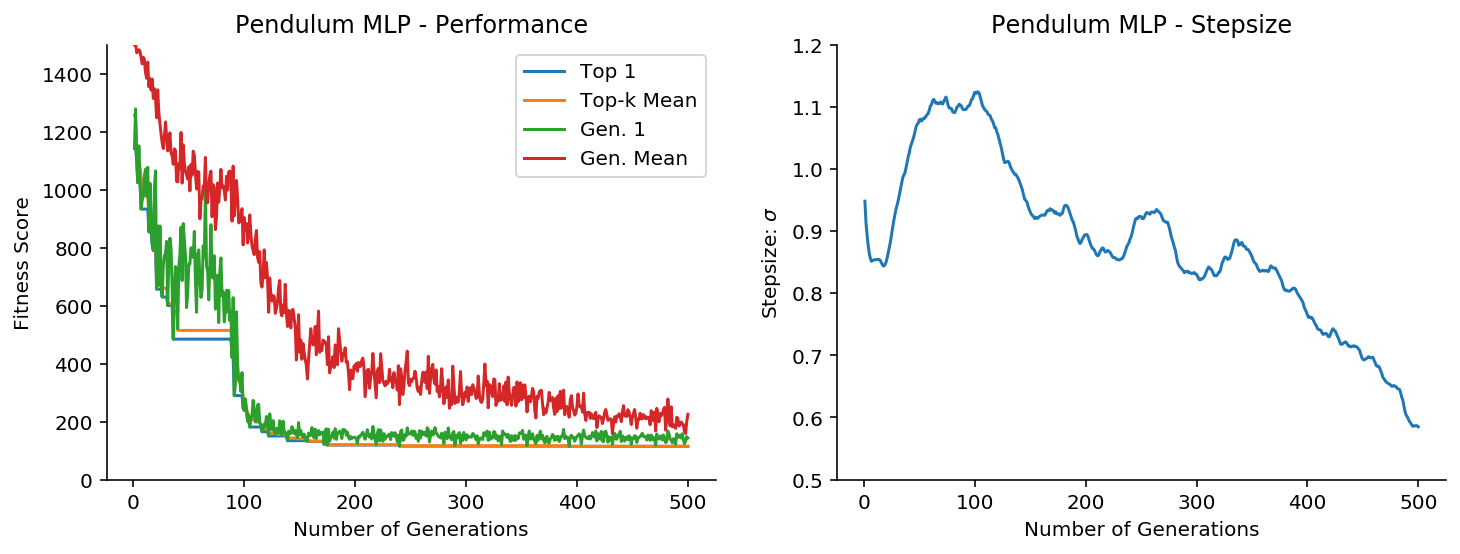

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_fitness(evo_logger, title="Pendulum MLP - Performance", ylims=(0, 1500), fig=fig, ax=axs[0])
plot_sigma(evo_logger, title="Pendulum MLP - Stepsize", ylims=(0.5, 1.2), fig=fig, ax=axs[1])